In [1]:
from pymongo import MongoClient
from sshtunnel import SSHTunnelForwarder
import pprint
from bson.objectid import ObjectId
import pyperclip as clip
import json
import tensorflow as tf
import pandas as pd
import numpy as np
import itertools as it
# from datasu import auc
# import pixiedust
# clip.copy(json.dumps(m1['msg']))


import nbimporter
from nbimporter import NotebookLoader
loader = NotebookLoader()
from common_functions import *
from common_functions_message import *
Message = loader.load_module("common_functions_message").Message

pd.options.mode.chained_assignment = None  # default='warn'


Importing Jupyter notebook from common_functions.ipynb
Importing Jupyter notebook from common_functions_message.ipynb
Importing Jupyter notebook from common_functions_message.ipynb


In [2]:
notebook_name = 'STS1-v2.4'

### funcs

In [3]:
def get_emb_from_cache(text, metadata):   
    q = create_embeddings_cache_query(text,metadata)
    emb_entry = db.embeddings_cache.find_one(q)
    return emb_entry['vector']

def encode_value(value, metadata):
    if isinstance(value,str):
        values = [value]
    else:
        values = value
            
    embs_list = list(map(lambda v: get_emb_from_cache(v,metadata),values))
    return np.array(embs_list)

In [4]:
# def get_metadata(embs, field, index):
#     meta = embs[field][index]
#     dimensions = len(meta['vector'])
#     del meta['vector']     
#     metadata = {            
#         **meta,
#         **{'dimensions': dimensions}
#     }
#     return metadata

### load data

In [5]:
# MONGO_HOST = "ec2-52-23-187-115.compute-1.amazonaws.com"
# MONGO_DB = "marketpulzz"
# server = SSHTunnelForwarder(
#     MONGO_HOST,
#     ssh_username='ubuntu',
#     ssh_pkey="/Users/sasha/.ssh/mmuze.pem",
# #     ssh_private_key_password="secret",
#     remote_bind_address=('127.0.0.1', 27017),
#     local_bind_address=('127.0.0.1', 63327),
#     set_keepalive = 5,
# )

# server.start()
# client = MongoClient('127.0.0.1', server.local_bind_port) # server.local_bind_port is assigned local port
# db = client[MONGO_DB]

In [6]:
MONGO_DB = "marketpulzz"
client = MongoClient('127.0.0.1', 27017)
db = client[MONGO_DB]

In [7]:
# m = db.genie_conversation_messages_emb.find_one({})

# bert_embs_map = {
#     'text': 15
# }

# bert_metadata = get_metadata(m['embs'],'text',bert_embs_map['text'])
# bert_metadata

In [8]:
sample_mt = db.genie_master_tags.find_one({"intents.0":{'$exists':True}})
mess = db.genie_conversation_messages.find_one({"_id": sample_mt['conversation_message_id']})    
fields = list(map(lambda f: f[0], Message(mess).get_fields_for_vector()))
fields

['text',
 'positive_product_type_tags',
 'negative_product_type_tags',
 'positive_aspects',
 'negative_aspects']

In [9]:
# fixed_cat_values = 2
fields_vector_len = {      
    'positive_product_type_tags': 2,
    'negative_product_type_tags': 2,
    'positive_aspects': 2,
    'negative_aspects': 2,
    'text':1
}


fields_vector_desc = {  
 'positive_product_type_tags': 'emb(2)',
 'negative_product_type_tags': 'emb(2)',
 'positive_aspects': 'emb(2)',
 'negative_aspects': 'emb(2)',
 'text': 'emb(1)'
}

exp_metadata = {    
  'msg_vector_desc': fields_vector_desc,
  'fields': fields
}

In [10]:
def get_message_for_master_tag(mt):   
    mess = db.genie_conversation_messages.find_one({"_id": mt['conversation_message_id']})    
    fields = Message(mess).get_fields_for_vector(fixed_length_by_field=fields_vector_len, fld_name_suffix=None)
    
#     def extr_intent(intent):
#         row = {**{'intent':intent['name'], 'tag':intent['tag']}, **dict(fields)}   
#         retun 
    intents = mt['intents']
    rows = list(map(lambda intent:{**{'intent':intent['name'], 'tag':intent['tag']}, **dict(fields)}, intents))
    return rows
    
master_tags_cursor = db.genie_master_tags.find({"intents.0":{'$exists':True}})
data = list(it.chain(*map(get_message_for_master_tag, master_tags_cursor)))

In [11]:
field_except_text = list(set(fields) - set(['text']))

In [12]:
df_data_all_unfiltered = pd.DataFrame(data)
df_data_all = df_data_all_unfiltered.loc[np.array(df_data_all_unfiltered.tag=='true')].copy()
rows_with_fields_mask = np.array(df_data_all[field_except_text].apply(lambda row: row.apply(lambda values: len(list((filter(lambda v: v!='*',values))))).sum() > 0,axis=1))
df_data_all = df_data_all.loc[rows_with_fields_mask].copy()
# df_data_all[0:150]['intent'] = 'refund'
# df_data_all[0:150]['text'] = 'I want my money back as soon as possible. Thanks'
df_data_all.head()

,intent,negative_aspects,negative_product_type_tags,positive_aspects,positive_product_type_tags,tag,text
94,Customer Support,"[*, *]","[*, *]","[concern, price]","[*, *]",true,[after paying I noticed that there were none o...
247,Frustration,"[price, *]","[*, *]","[*, *]","[*, *]",true,[I am very cross that this is turning out to b...
251,Frustration,"[price, *]","[*, *]","[*, *]","[*, *]",true,[right i think i wasted sp much money haven't ...
259,Order Information,"[*, *]","[*, *]","[size eu, size uk]","[*, *]",true,[Please provide the status of my order number ...
270,Order Information,"[*, *]","[*, *]","[size, size eu]","[*, *]",true,"[Hello good morning, use an order on the 25th ..."


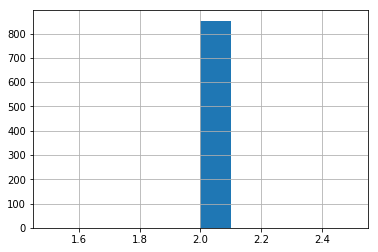

In [13]:
# np.histogram(df_data_all['negative_product_type_tags'].apply(len))
df_data_all['positive_aspects'].apply(len).hist()

### encode data

##### BERT

In [14]:
bert_metadata = {            
    'version': '1.0',
    'encoder': 'BERT',
    'model': 'uncased_L-12_H-768_A-12',    
    'max_seq_len': 200,
    'pooling_strategy': 'REDUCE_MEAN', 
    'pooling_layer': '-5',
    'dimensions':768
}

In [15]:
%%time
bert_embs = df_data_all[fields].applymap(lambda v: encode_value(v,bert_metadata))
df_data_all['emb_bert'] = bert_embs.apply(lambda cols_embs: np.concatenate(cols_embs, axis=None), axis=1)

CPU times: user 4.14 s, sys: 293 ms, total: 4.43 s
Wall time: 1min 5s


In [16]:
df_data_all.head()

,intent,negative_aspects,negative_product_type_tags,positive_aspects,positive_product_type_tags,tag,text,emb_bert
94,Customer Support,"[*, *]","[*, *]","[concern, price]","[*, *]",true,[after paying I noticed that there were none o...,"[0.03474654257297516, -0.04883496090769768, -0..."
247,Frustration,"[price, *]","[*, *]","[*, *]","[*, *]",true,[I am very cross that this is turning out to b...,"[-0.2906862497329712, -0.07694011181592941, 0...."
251,Frustration,"[price, *]","[*, *]","[*, *]","[*, *]",true,[right i think i wasted sp much money haven't ...,"[0.5273053050041199, 0.2969871759414673, 0.008..."
259,Order Information,"[*, *]","[*, *]","[size eu, size uk]","[*, *]",true,[Please provide the status of my order number ...,"[-0.12966743111610413, -0.2640830874443054, 0...."
270,Order Information,"[*, *]","[*, *]","[size, size eu]","[*, *]",true,"[Hello good morning, use an order on the 25th ...","[0.09603890776634216, 0.11418843269348145, 0.4..."


##### USE

In [17]:
use_metadata = {
    'version': '1.0',
    'encoder': 'USE',   
    'model': 'https://tfhub.dev/google/universal-sentence-encoder-large/3',
    'dimensions':512
}

In [18]:
%%time
use_embs = df_data_all[fields].applymap(lambda v: encode_value(v,use_metadata))
df_data_all['emb_use'] = use_embs.apply(lambda cols_embs: np.concatenate(cols_embs, axis=None), axis=1)

CPU times: user 3.97 s, sys: 269 ms, total: 4.24 s
Wall time: 1min 10s


In [19]:
df_data_all.head()

,intent,negative_aspects,negative_product_type_tags,positive_aspects,positive_product_type_tags,tag,text,emb_bert,emb_use
94,Customer Support,"[*, *]","[*, *]","[concern, price]","[*, *]",true,[after paying I noticed that there were none o...,"[0.03474654257297516, -0.04883496090769768, -0...","[-0.027131514623761177, 0.043605491518974304, ..."
247,Frustration,"[price, *]","[*, *]","[*, *]","[*, *]",true,[I am very cross that this is turning out to b...,"[-0.2906862497329712, -0.07694011181592941, 0....","[-0.02255561389029026, -0.02099185436964035, 0..."
251,Frustration,"[price, *]","[*, *]","[*, *]","[*, *]",true,[right i think i wasted sp much money haven't ...,"[0.5273053050041199, 0.2969871759414673, 0.008...","[0.05168059840798378, 0.0713871493935585, -0.0..."
259,Order Information,"[*, *]","[*, *]","[size eu, size uk]","[*, *]",true,[Please provide the status of my order number ...,"[-0.12966743111610413, -0.2640830874443054, 0....","[-0.044379543513059616, -0.045448899269104004,..."
270,Order Information,"[*, *]","[*, *]","[size, size eu]","[*, *]",true,"[Hello good morning, use an order on the 25th ...","[0.09603890776634216, 0.11418843269348145, 0.4...","[-0.0315515361726284, -0.03231652453541756, -0..."


### evaluation

In [55]:
pipeline = [
{'$unwind': '$intents'},
{'$project' : {'_id': 0, 'intents.name' : 1 , 'intents.category' : 1, 'intents.tag' : 1 } },
{'$group' : {
       '_id' : { 
            'name': "$intents.name", 
            'category': '$intents.category', 
            'tag': '$intents.tag' 
        },
        'name': {'$first': "$intents.name"}, 
        'category': {'$first':'$intents.category'}, 
        'tag': {'$first':'$intents.tag'},      
        'count': { '$sum': 1 }
    }
},
{'$project' : {'_id': 0, 'name' : 1 , 'category' : 1, 'tag' : 1,'count' : 1 }}
]

master_tag_stats = list(db.genie_master_tags.aggregate(pipeline))
df_master_tag_stats = pd.DataFrame(master_tag_stats, columns=['category','name','tag','count'])
df_master_tag_stats.pivot(index='name',values=['count'],columns='tag')

count              
tag                          amb  false   true
name                                          
Add to Wishlist              NaN   18.0    4.0
Back                         NaN   29.0   17.0
Compare                      NaN   24.0    NaN
Complementary                NaN  105.0   63.0
Customer Support             1.0   26.0  631.0
Frustration                  8.0   97.0   13.0
Help                         NaN   48.0   16.0
Introduction                 NaN   17.0    8.0
More                        34.0   32.0   17.0
New Facecare Regimen         NaN  238.0   95.0
Order Information            NaN  116.0  367.0
Product Aspect Information   NaN  122.0   90.0
Product not found            NaN  128.0  396.0
Shop new arrivals            2.0    1.0    4.0

In [56]:
def smooth_intent_prob(w):
    return w*100 if w < 0.01 else w

# print("total count: ",df_data_all.shape[0])
# df_data_agg_by_intent = pd.DataFrame(df_data_all.groupby(['intent']).count()['tag'])
# df_data_agg_by_intent.rename(columns={'tag':'count'}, inplace=True)
# df_data_agg_by_intent['intent_prob'] = df_data_agg_by_intent/df_data_agg_by_intent.sum()
# df_data_agg_by_intent['intent_prob_smoothed'] = df_data_agg_by_intent['intent_prob'].apply(smooth_intent_prob)
# df_data_agg_by_intent

#calc intent pro
df_data_all['intent_prob'] = 1.0#df_data_all.groupby(['intent']).transform('count')['text']/df_data_all.shape[0]
# df_data_all['intent_prob_weighted'] = df_data_all.groupby(['intent']).transform('count')['text']/df_data_all.shape[0]
# df_data_all['intent_prob_smoothed'] = df_data_all['intent_prob'].apply(smooth_intent_prob)
print("max message length: ", df_data_all['text'].map(len).max())
df_data_all.head(n=5)

max message length:  1


,intent,negative_aspects,negative_product_type_tags,positive_aspects,positive_product_type_tags,tag,text,emb_bert,emb_use,intent_prob
94,Customer Support,"[*, *]","[*, *]","[concern, price]","[*, *]",true,[after paying I noticed that there were none o...,"[0.03474654257297516, -0.04883496090769768, -0...","[-0.027131514623761177, 0.043605491518974304, ...",1.0
247,Frustration,"[price, *]","[*, *]","[*, *]","[*, *]",true,[I am very cross that this is turning out to b...,"[-0.2906862497329712, -0.07694011181592941, 0....","[-0.02255561389029026, -0.02099185436964035, 0...",1.0
251,Frustration,"[price, *]","[*, *]","[*, *]","[*, *]",true,[right i think i wasted sp much money haven't ...,"[0.5273053050041199, 0.2969871759414673, 0.008...","[0.05168059840798378, 0.0713871493935585, -0.0...",1.0
259,Order Information,"[*, *]","[*, *]","[size eu, size uk]","[*, *]",true,[Please provide the status of my order number ...,"[-0.12966743111610413, -0.2640830874443054, 0....","[-0.044379543513059616, -0.045448899269104004,...",1.0
270,Order Information,"[*, *]","[*, *]","[size, size eu]","[*, *]",true,"[Hello good morning, use an order on the 25th ...","[0.09603890776634216, 0.11418843269348145, 0.4...","[-0.0315515361726284, -0.03231652453541756, -0...",1.0


In [57]:
N = 300
df_query = df_data_all.sample(n=N, weights='intent_prob',random_state=888)
# df_query = df_data_all.sample(n=N, weights='intent_prob',random_state=108)
df_query
df_data = df_data_all.drop(df_query.index)

df_query_stats = pd.DataFrame()
df_query_stats['data'] = df_data.groupby(['intent']).count()['text']
df_query_stats['query'] = df_query.groupby(['intent']).count()['text']
df_query_stats['query_TP'] = df_query_stats['query']*df_query_stats['data']
df_query_stats['Q/D ratio'] = round(df_query_stats['query']/df_query_stats['data'],3)

data_metadata = {
    'intents': df_query_stats.index.values.tolist(),
    'data_query_stats':df_query_stats.to_dict()
}

print(df_query_stats)
print("")
print(f"total: {len(df_data_all)} => query:{len(df_query)} + data:{len(df_data)}")
total_rows = len(df_query)*len(df_data)
total_TP = df_query_stats['query_TP'].sum()
print(f"total rows:{total_rows} => total TP:{total_TP} TP_ratio:{round(df_query_stats['query_TP'].sum()/total_rows, 2)}")

                            data  query  query_TP  Q/D ratio
intent                                                      
Back                           5      2        10      0.400
Complementary                 35     17       595      0.486
Customer Support             265    133     35245      0.502
Frustration                    1      1         1      1.000
New Facecare Regimen          27     23       621      0.852
Order Information             48     28      1344      0.583
Product Aspect Information    60     30      1800      0.500
Product not found            111     65      7215      0.586
Shop new arrivals              1      1         1      1.000

total: 853 => query:300 + data:553
total rows:165900 => total TP:46832 TP_ratio:0.28


In [58]:
df_eval = df_crossjoin(df_query[['emb_bert', 'emb_use', 'intent']], df_data, suffixes=('_q', ''))
# df_eval = df_crossjoin(df_query[['emb_use', 'intent']], df_data, suffixes=('_q', ''))
# df_eval = df_crossjoin(df_query[['emb_bert', 'intent']], df_data, suffixes=('_q', ''))

df_eval['is_same_intent'] = (df_eval['intent_q'] == df_eval['intent']).values
print("total rows: ",df_eval.shape[0])
df_eval.head(n=5)

total rows:  165900


emb_bert_q  \
2239 94   [0.47819599509239197, -0.07518669962882996, 0....   
     251  [0.47819599509239197, -0.07518669962882996, 0....   
     259  [0.47819599509239197, -0.07518669962882996, 0....   
     270  [0.47819599509239197, -0.07518669962882996, 0....   
     272  [0.47819599509239197, -0.07518669962882996, 0....   

                                                  emb_use_q          intent_q  \
2239 94   [-0.007315723691135645, 0.07108025997877121, 0...  Customer Support   
     251  [-0.007315723691135645, 0.07108025997877121, 0...  Customer Support   
     259  [-0.007315723691135645, 0.07108025997877121, 0...  Customer Support   
     270  [-0.007315723691135645, 0.07108025997877121, 0...  Customer Support   
     272  [-0.007315723691135645, 0.07108025997877121, 0...  Customer Support   

                     intent negative_aspects negative_product_type_tags  \
2239 94    Customer Support           [*, *]                     [*, *]   
     251        Frustration       [price, *]                     [*, *]   
     259  Order Information           [*, *]                     [*, *]   
     270  Order Information           [*, *]                     [*, *]   
     272  Order Information           [*, *]                     [*, *]   

            positive_aspects positive_product_type_tags   tag  \
2239 94     [concern, price]                     [*, *]  true   
     251              [*, *]                     [*, *]  true   
     259  [size eu, size uk]                     [*, *]  true   
     270     [size, size eu]                     [*, *]  true   
     272     [size, size eu]                     [*, *]  true   

                                                       text  \
2239 94   [after paying I noticed that there were none o...   
     251  [right i think i wasted sp much money haven't ...   
     259  [Please provide the status of my order number ...   
     270  [Hello good morning, use an order on the 25th ...   
     272  [Can you please provide the status of item 173...   

                                                   emb_bert  \
2239 94   [0.03474654257297516, -0.04883496090769768, -0...   
     251  [0.5273053050041199, 0.2969871759414673, 0.008...   
     259  [-0.12966743111610413, -0.2640830874443054, 0....   
     270  [0.09603890776634216, 0.11418843269348145, 0.4...   
     272  [-0.17244482040405273, -0.48103517293930054, 0...   

                                                    emb_use  intent_prob  \
2239 94   [-0.027131514623761177, 0.043605491518974304, ...          1.0   
     251  [0.05168059840798378, 0.0713871493935585, -0.0...          1.0   
     259  [-0.044379543513059616, -0.045448899269104004,...          1.0   
     270  [-0.0315515361726284, -0.03231652453541756, -0...          1.0   
     272  [-0.009103391319513321, -0.012394025921821594,...          1.0   

          is_same_intent  
2239 94             True  
     251           False  
     259           False  
     270           False  
     272           False

In [59]:
ev_results = []
def add_ev_res(res, encoder, emb_metadata, exp_metadata, data_metadata):  
    metric = [{'name':k, 'value':v} for k,v in res.items()][0]
    ev_res = {
        'notebook': notebook_name,
        'encoder':encoder,
        'emb_metadata': emb_metadata, 
        'exp_metadata':exp_metadata,
        'metric': metric,
        'data_metadata': data_metadata
    }    
    
#     ev_res = {**exp, **res}    
    ev_results.append(ev_res)

In [60]:
# import sys

# # These are the usual ipython objects, including this one you are creating
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# # Get a sorted list of the objects and their sizes
# sorted([(x, sys.getsizeof(globals().get(x))/10**9) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

#### evaluate BERT

In [61]:
%%time
def calc_dist_use(df):
    emb_query_arr = np.stack(df['emb_bert_q'].values)
    emb_data_arr = np.stack(df['emb_bert'].values)
    angdist, cossim = sim_exact(emb_query_arr, emb_data_arr)
    df['angdist_bert'] = angdist#.diagonal()
    df['cossim_bert'] = cossim#.diagonal()    
    return df

df_eval = apply_by_chunks(df_eval, 30000, calc_dist_use)
df_eval_by_angdist_bert = df_eval.sort_values(by=['angdist_bert'], ascending=False)[0:total_TP]
df_eval_by_angdist_bert.head()

CPU times: user 56.8 s, sys: 51.3 s, total: 1min 48s
Wall time: 33.8 s


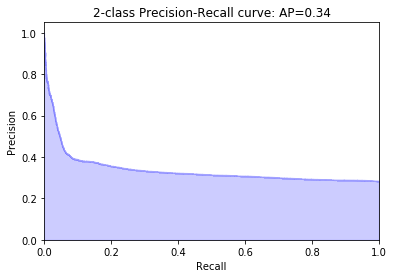

In [62]:
MAP_DQ_bert = plot_precision_recall_curve(df_eval['angdist_bert'].values, df_eval['is_same_intent'].values)
add_ev_res({'MAP_DQ':MAP_DQ_bert}, 'bert', bert_metadata, exp_metadata, data_metadata)

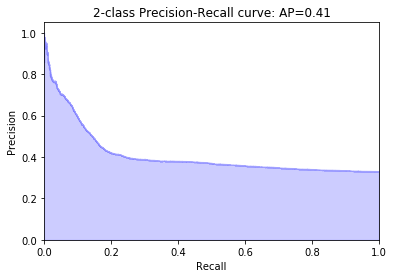

In [63]:
MAP_TP_bert = plot_precision_recall_curve(df_eval_by_angdist_bert['angdist_bert'].values, df_eval_by_angdist_bert['is_same_intent'].values)
add_ev_res({'MAP_TP':MAP_TP_bert}, 'bert', bert_metadata, exp_metadata, data_metadata)

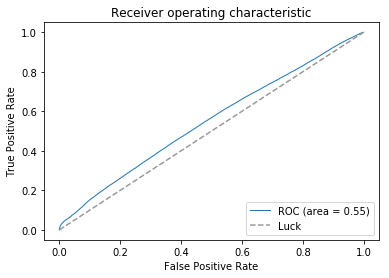

In [64]:
AUC_DQ_bert = plot_auc_curve(df_eval['angdist_bert'].values, df_eval['is_same_intent'].values)
add_ev_res({'AUC_DQ':AUC_DQ_bert}, 'bert', bert_metadata, exp_metadata, data_metadata)

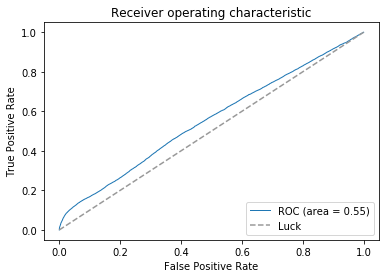

In [65]:
AUC_TP_bert = plot_auc_curve(df_eval_by_angdist_bert['angdist_bert'].values, df_eval_by_angdist_bert['is_same_intent'].values)
add_ev_res({'AUC_TP':AUC_TP_bert}, 'bert', bert_metadata, exp_metadata, data_metadata)

#### evaluate USE

In [66]:
%%time
def calc_dist_use(df):
    emb_query_arr = np.stack(df['emb_use_q'].values)
    emb_data_arr = np.stack(df['emb_use'].values)
    angdist, cossim = sim_exact(emb_query_arr, emb_data_arr)
    df['angdist_use'] = angdist#.diagonal()
    df['cossim_use'] = cossim#.diagonal()    
    return df

df_eval = apply_by_chunks(df_eval, 30000, calc_dist_use)
df_eval_res_by_angdist_use = df_eval.sort_values(by=['angdist_use'], ascending=False)[0:total_TP]

CPU times: user 38.7 s, sys: 30 s, total: 1min 8s
Wall time: 19 s


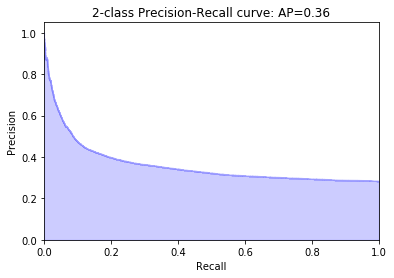

In [67]:
MAP_DQ_use = plot_precision_recall_curve(df_eval['angdist_use'].values, df_eval['is_same_intent'].values)
add_ev_res({'MAP_DQ':MAP_DQ_use}, 'use', use_metadata, exp_metadata, data_metadata)

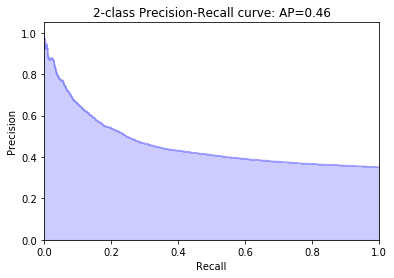

In [68]:
MAP_TP_use = plot_precision_recall_curve(df_eval_res_by_angdist_use['angdist_use'].values, df_eval_res_by_angdist_use['is_same_intent'].values)
add_ev_res({'MAP_TP':MAP_TP_use}, 'use', use_metadata, exp_metadata, data_metadata)

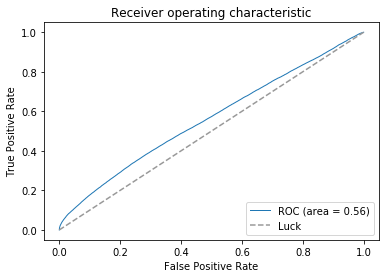

In [69]:
AUC_DQ_use = plot_auc_curve(df_eval['angdist_use'].values, df_eval['is_same_intent'].values)
add_ev_res({'AUC_DQ':AUC_DQ_use}, 'use', use_metadata, exp_metadata, data_metadata) 

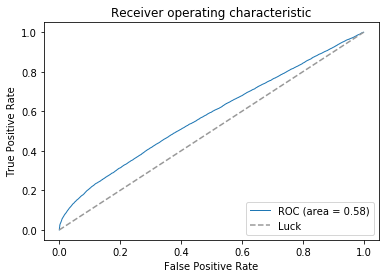

In [70]:
AUC_TP_use = plot_auc_curve(df_eval_res_by_angdist_use['angdist_use'].values, df_eval_res_by_angdist_use['is_same_intent'].values)
add_ev_res({'AUC_TP':AUC_TP_use}, 'use', use_metadata, exp_metadata, data_metadata)  

#### save results

In [71]:
ev_results[0]

{'notebook': 'STS1-v2.4',
 'encoder': 'bert',
 'emb_metadata': {'version': '1.0',
  'encoder': 'BERT',
  'model': 'uncased_L-12_H-768_A-12',
  'max_seq_len': 200,
  'pooling_strategy': 'REDUCE_MEAN',
  'pooling_layer': '-5',
  'dimensions': 768},
 'exp_metadata': {'msg_vector_desc': {'positive_product_type_tags': 'emb(2)',
   'negative_product_type_tags': 'emb(2)',
   'positive_aspects': 'emb(2)',
   'negative_aspects': 'emb(2)',
   'text': 'emb(1)'},
  'fields': ['text',
   'positive_product_type_tags',
   'negative_product_type_tags',
   'positive_aspects',
   'negative_aspects']},
 'metric': {'name': 'MAP_DQ', 'value': 0.3380886410505853},
 'data_metadata': {'intents': ['Back',
   'Complementary',
   'Customer Support',
   'Frustration',
   'New Facecare Regimen',
   'Order Information',
   'Product Aspect Information',
   'Product not found',
   'Shop new arrivals'],
  'data_query_stats': {'data': {'Back': 5,
    'Complementary': 35,
    'Customer Support': 265,
    'Frustration': 

In [72]:
db.sts1_bert_use.insert_many(ev_results)